# imports

In [1]:
#import Cython
import os
import contextlib
import enum
import json
import os
import pathlib
import typing as tp
import uuid
from tqdm import tqdm
import copy
from collections import Counter
from  itertools import chain

#ds
import sklearn
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()


#dl
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
import torch
import transformers
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizer
from keras_preprocessing.sequence import pad_sequences

In [2]:
torch.cuda.is_available()

True

In [29]:
# If there's a GPU available...
if torch.cuda.is_available():    
    number = 5
    # Tell PyTorch to use the GPU.    
    device = torch.device(f"cuda:{number}")
    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(number))
    torch.cuda.set_device(device)
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 6 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1080


In [30]:
device

device(type='cuda', index=5)

In [28]:
for i in range(6):
    device = torch.device(f"cuda:{i}")
    torch.cuda.empty_cache()

In [53]:
class Logger:
    def __init__(self, logs_path: tp.Union[str, os.PathLike]):
        self.path = pathlib.Path(logs_path)

        records = []
        for root, dirs, files in os.walk(self.path):
            for file in files:
                if file.lower().endswith('.json'):
                    uuid = os.path.splitext(file)[0]
                    with open(os.path.join(root, file), 'r') as f:
                        try:
                            logged_data = json.load(f)
                            records.append(
                                {
                                    'id': uuid,
                                    **logged_data
                                }
                            )
                        except json.JSONDecodeError:
                            pass
        if records:
            self.leaderboard = pd.DataFrame.from_records(records, index='id')
        else:
            self.leaderboard = pd.DataFrame(index=pd.Index([], name='id'))

        self._current_run = None

    class Run:

        def __init__(self, name, storage, path):
            self.name = name
            self._storage = storage
            self._path = path
            self._storage.append(pd.Series(name=name))

        def log(self, key, value):
            self._storage.loc[self.name, key] = value

        def log_values(self, log_values: tp.Dict[str, tp.Any]):
            for key, value in log_values.items():
                self.log(key, value)

        def save_logs(self):
            with open(self._path / f'{self.name}.json', 'w+') as f:
                json.dump(self._storage.loc[self.name].to_dict(), f)

        def log_artifact(self, fname: str, writer: tp.Callable):
            with open(self._path / fname, 'wb+') as f:
                writer(f)

    @contextlib.contextmanager
    def run(self, name: tp.Optional[str] = None):
        if name is None:
            name = str(uuid.uuid4())
        elif name in self.leaderboard.index:
            raise NameError("Run with given name already exists, name should be unique")
        else:
            name = name.replace(' ', '_')
        self._current_run = Logger.Run(name, self.leaderboard, self.path / name)
        os.makedirs(self.path / name, exist_ok=True)
        try:
            yield self._current_run
        finally:
            self._current_run.save_logs()

In [54]:
logger = Logger('./logs')

## formality bert evaluation for courseworks

In [3]:
test_df = pd.read_csv("validation_exploring.csv")

In [13]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [12]:
!pip install torchvision

  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)


In [16]:
!pip uninstall nvidia_cublas_cu11 -y

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Found existing installation: nvidia-cublas-cu11 11.10.3.66
Uninstalling nvidia-cublas-cu11-11.10.3.66:
  Successfully uninstalled nvidia-cublas-cu11-11.10.3.66


In [18]:
from transformers import XLMRobertaTokenizerFast, XLMRobertaForSequenceClassification

# load tokenizer and model weights
#tokenizer = XLMRobertaTokenizerFast.from_pretrained('s-nlp/xlmr_formality_classifier')
model = XLMRobertaForSequenceClassification.from_pretrained('s-nlp/xlmr_formality_classifier')

OSError: Unable to load weights from pytorch checkpoint file for '/home/alrabosh/.cache/huggingface/hub/models--s-nlp--xlmr_formality_classifier/snapshots/b491648728ab0fab087598e4eea3e123be7155e6/pytorch_model.bin' at '/home/alrabosh/.cache/huggingface/hub/models--s-nlp--xlmr_formality_classifier/snapshots/b491648728ab0fab087598e4eea3e123be7155e6/pytorch_model.bin'. If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True.

In [14]:
test_df['formality_token'] = test_df.text.progress_apply(lambda x: tokenizer.encode(x, add_special_tokens = True))
test_df["formality_token_len"] = test_df["formality_token"].progress_apply(len)
print('Max sentence length: ', max(test_df['formality_token_len']))

 26%|█████████████████████████████████████████████████▋                                                                                                                                                | 4989/19500 [00:04<00:11, 1222.06it/s]


KeyboardInterrupt: 

In [ ]:
MAX_LEN = 128

pads = pad_sequences(test_df['formality_token'], maxlen=128 , truncating="post", padding="post")
labels = test_df.target.values
test_df['pads'] = pd.Series(list(pads))
test_df['attention_masks'] = test_df.pads.progress_apply(lambda x: [int(token_id > 0) for token_id in x])

X_train, X_test, y_train, y_test = train_test_split(pads, labels, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(test_df['attention_masks'], labels,test_size=0.2)

In [ ]:
X_test = torch.tensor(list(test_df.pads.values))

y_test = torch.tensor(list(test_df.target.values))

validation_masks = torch.tensor(list(test_df.attention_masks.values))

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
validation_data = TensorDataset(X_test, validation_masks, y_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
model.cuda()

In [ ]:
model.eval()
batches_logits = []

for idx, batch in enumerate(validation_dataloader):
    if idx % 50 == 0:
        print(f"{idx} batch of {len(validation_dataloader)}")
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
        
        
    with torch.no_grad():        
        outputs = model(b_input_ids, 
        #token_type_ids=None, 
        attention_mask=b_input_mask)

    logits = outputs[0]
    
    batches_logits.append(logits.detach().cpu().numpy())

In [ ]:
logits = []
for batch in batches_logits:
    for logit in batch:
        logits.append(logit)
logits = np.array(logits)

In [ ]:
logits

In [117]:
test_df['formal_score'] = logits[:,0]
test_df['informal_score'] = logits[:,1]


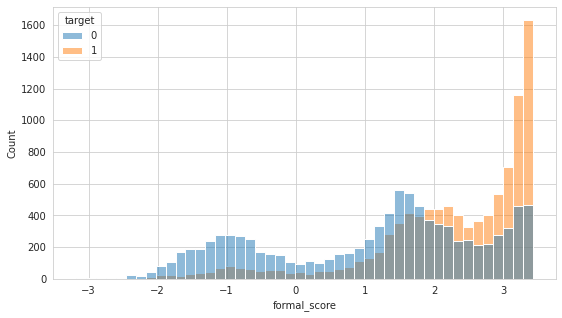

In [126]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(9, 5))
    sns.histplot(data=test_df, x='formal_score', hue='target')

In [131]:
test_df["formal_prediction"] = (test_df['formal_score'] > test_df['informal_score']).astype(int)

In [136]:
list(test_df[(test_df['formal_prediction'] == 1) & (test_df['prediction'] == 0)].text)

['Основная его идея следующая: у многих индексов есть общие свойства, так, например, во многих деревьях поиска, ссылки на сами данные располагаются только на последнем уровне, при этом все листья находятся на одинаковом расстоянии от корня.',
 'Это двунаправленный поиск, с расслабленными требованиями к функции-эвристике, и очень агрессивным критерием завершения.',
 'Для работы достаточно знания JavaScript и специфики NodeJS.API-документирован и доступен для тестирования сторонними front-end разработчиками.',
 'Счастья не будет.',
 'При этом один из наших сотрудников играет роль клиента, с которым можно общаться.',
 'Хорошая статья, детально описывающая аспекты применения GBM: Gradient boosting machines, a tutorial.',
 'Можете посмотреть его статью Nine Steps to Start a Software Project.',
 'Страница13 с лицензией проекта.',
 'Модули – грубо говоря — это программа, которую можно динамично и быстро добавить в kernel space, после чего, модуль станет частью операционной системы и получит б

## combine dataset for bert

In [3]:
train_df = pd.read_csv("bert_train_58k.csv")
test_df = pd.read_csv("bert_test_58k.csv")

In [4]:
train_df = train_df.sample(len(train_df))
test_df = test_df.sample(len(test_df))


In [5]:
df = pd.concat([train_df, test_df], ignore_index=True)

train_indices = slice(0, len(train_df))
test_indices = slice(len(train_df), len(df))

# bert

In [6]:
model_name = 'cointegrated/rubert-tiny'
pad_len = 128
train_size = len(train_df)
run_name = model_name.replace("/", "") + f"_{pad_len}_{train_size}"

In [7]:
run_name

'cointegratedrubert-tiny_128_59250'

In [32]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
df['token'] = df.text.progress_apply(lambda x: tokenizer.encode(x, add_special_tokens = True))
df["token_len"] = df["token"].progress_apply(len)
print('Max sentence length: ', max(df['token_len']))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79000/79000 [00:00<00:00, 1199674.21it/s]

Max sentence length:  460


In [33]:
MAX_LEN = pad_len

pads = pad_sequences(df['token'], maxlen=MAX_LEN , truncating="post", padding="post")
labels = df.target.values
df['pads'] = pd.Series(list(pads))
df['attention_masks'] = df.pads.progress_apply(lambda x: [int(token_id > 0) for token_id in x])

X_train, X_test, y_train, y_test = train_test_split(pads, labels, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(df['attention_masks'], labels,test_size=0.2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79000/79000 [00:24<00:00, 3216.42it/s]


In [34]:
X_train = torch.tensor(list(df[train_indices].pads.values))
X_test = torch.tensor(list(df[test_indices].pads.values))

y_train = torch.tensor(list(df[train_indices].target.values))
y_test = torch.tensor(list(df[test_indices].target.values))

train_masks = torch.tensor(list(df[train_indices].attention_masks.values))
validation_masks = torch.tensor(list(df[test_indices].attention_masks.values))

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 24
#print(X_train.shape,y_train.shape, train_masks.shape)
#DataLoader for our training set.
train_data = TensorDataset(X_train, train_masks, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(X_test, validation_masks, y_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [35]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    model_name,   
    output_attentions = False,
    output_hidden_states = False
)

# Running the model on GPU.
model.cuda()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

In [36]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [37]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

In [38]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(pred_flat, labels_flat)

def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(pred_flat, labels_flat, zero_division=0)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

result_metrics = {
    "Accuracy" : 0,
    "Recall" : 0,
    "Precision" : 0,
    "Validation_time" : 0
}
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if (step == 1800):
            pass
            #break
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy, eval_recall, eval_precision = 0, 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        tmp_eval_recall = flat_recall(logits, label_ids)
        tmp_eval_precision = flat_precision(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy
        eval_precision += tmp_eval_precision
        eval_recall += tmp_eval_recall 
        
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    result_metrics["Accuracy"] = eval_accuracy/nb_eval_steps
    result_metrics["Recall"] = eval_recall/nb_eval_steps
    result_metrics["Precision"] = eval_precision/nb_eval_steps

    print("  Accuracy: {0:.2f}".format(result_metrics["Accuracy"]))
    print("  Recall: {0:.2f}".format(result_metrics["Recall"]))
    print("  Precision: {0:.2f}".format(result_metrics["Precision"]))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,469.    Elapsed: 0:00:05.
  Batch    80  of  2,469.    Elapsed: 0:00:09.
  Batch   120  of  2,469.    Elapsed: 0:00:13.
  Batch   160  of  2,469.    Elapsed: 0:00:17.
  Batch   200  of  2,469.    Elapsed: 0:00:21.
  Batch   240  of  2,469.    Elapsed: 0:00:25.
  Batch   280  of  2,469.    Elapsed: 0:00:29.
  Batch   320  of  2,469.    Elapsed: 0:00:33.
  Batch   360  of  2,469.    Elapsed: 0:00:37.
  Batch   400  of  2,469.    Elapsed: 0:00:41.
  Batch   440  of  2,469.    Elapsed: 0:00:45.
  Batch   480  of  2,469.    Elapsed: 0:00:49.
  Batch   520  of  2,469.    Elapsed: 0:00:53.
  Batch   560  of  2,469.    Elapsed: 0:00:56.
  Batch   600  of  2,469.    Elapsed: 0:01:00.
  Batch   640  of  2,469.    Elapsed: 0:01:04.
  Batch   680  of  2,469.    Elapsed: 0:01:08.
  Batch   720  of  2,469.    Elapsed: 0:01:12.
  Batch   760  of  2,469.    Elapsed: 0:01:16.
  Batch   800  of  2,469.    Elapsed: 0:01:20.
  Batch   840  of

In [55]:
run_name

'cointegratedrubert-tiny_128_59250'

In [56]:
with logger.run(name=run_name) as run:
            run.log_values(result_metrics)

/tmp/ipykernel_1598701/2966208136.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/tmp/ipykernel_1598701/2966208136.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))


In [57]:
logger.leaderboard

precision  acur  smth  Accuracy  \
id                                                                           
cointegratedrubert-tiny_128_125000               NaN   NaN   NaN  0.888435   
cointegratedrubert-tiny_128_58500_24batch        NaN   NaN   NaN  0.843788   
cointegratedrubert-tiny_128_10000_old            NaN   NaN   NaN  0.812101   
cointegratedrubert-tiny_128_60000                NaN   NaN   NaN  0.855800   
cointegratedrubert-tiny_128_10000                NaN   NaN   NaN  0.819888   
cointegratedrubert-tiny_128_58500                NaN   NaN   NaN  0.841615   
cointegratedrubert-tiny_128_59250                NaN   NaN   NaN  0.872087   

                                             Recall  Precision  \
id                                                               
cointegratedrubert-tiny_128_125000         0.573226   0.810222   
cointegratedrubert-tiny_128_58500_24batch  0.827447   0.868516   
cointegratedrubert-tiny_128_10000_old      0.793464   0.845872   
cointegratedrubert-tiny_128_60000          0.829052   0.896465   
cointegratedrubert-tiny_128_10000          0.787348   0.874815   
cointegratedrubert-tiny_128_58500          0.824910   0.869250   
cointegratedrubert-tiny_128_59250          0.864875   0.881249   

                                           Validation_time  
id                                                          
cointegratedrubert-tiny_128_125000                     0.0  
cointegratedrubert-tiny_128_58500_24batch              0.0  
cointegratedrubert-tiny_128_10000_old                  NaN  
cointegratedrubert-tiny_128_60000                      0.0  
cointegratedrubert-tiny_128_10000                      0.0  
cointegratedrubert-tiny_128_58500                      0.0  
cointegratedrubert-tiny_128_59250                      0.0

In [40]:
df[test_indices]

Unnamed: 0                                               text  target  \
59250       17247  Modular Scale — это система, определяющая соот...       0   
59251       11786  Этих знаний должно быть достаточно, чтобы поня...       0   
59252        9486  3. Реализован эвристический алгоритм поиска в ...       1   
59253        6804  Далее состовляется массив концов этих отрезков...       1   
59254        8842                                   Определение 3.6.       1   
...           ...                                                ...     ...   
78995        5922  Запросы на сервер логически можно разделить на...       1   
78996        9170  В целом структура модулей устроена таким образ...       1   
78997         924  В книгах для этого присутствуют оглавление и а...       1   
78998       16804  Мне кажется, мы не делаем абсолютно ничего так...       0   
78999        5728  Конечно, как и все APIинтерфейсы, реализация э...       1   

                                                   token  token_len  \
59250  [2, 22996, 4873, 16870, 1, 2389, 5155, 16, 326...         71   
59251  [2, 15134, 753, 319, 3575, 1546, 23343, 4678, ...         27   
59252  [2, 23, 18, 24728, 12666, 7247, 341, 21337, 23...         37   
59253  [2, 29213, 25742, 811, 13834, 26941, 23818, 88...         34   
59254                 [2, 294, 21276, 23, 18, 26, 18, 3]          8   
...                                                  ...        ...   
78995  [2, 1647, 27353, 700, 548, 689, 28637, 870, 98...         28   
78996  [2, 282, 15155, 8898, 324, 16923, 6145, 331, 1...         38   
78997  [2, 282, 8365, 753, 871, 3136, 1129, 4108, 288...         36   
78998  [2, 5065, 626, 26488, 6868, 16, 11521, 769, 78...         28   
78999  [2, 290, 13199, 3312, 16, 1150, 320, 2749, 143...         48   

                                                    pads  \
59250  [2, 22996, 4873, 16870, 1, 2389, 5155, 16, 326...   
59251  [2, 15134, 753, 319, 3575, 1546, 23343, 4678, ...   
59252  [2, 23, 18, 24728, 12666, 7247, 341, 21337, 23...   
59253  [2, 29213, 25742, 811, 13834, 26941, 23818, 88...   
59254  [2, 294, 21276, 23, 18, 26, 18, 3, 0, 0, 0, 0,...   
...                                                  ...   
78995  [2, 1647, 27353, 700, 548, 689, 28637, 870, 98...   
78996  [2, 282, 15155, 8898, 324, 16923, 6145, 331, 1...   
78997  [2, 282, 8365, 753, 871, 3136, 1129, 4108, 288...   
78998  [2, 5065, 626, 26488, 6868, 16, 11521, 769, 78...   
78999  [2, 290, 13199, 3312, 16, 1150, 320, 2749, 143...   

                                         attention_masks  
59250  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
59251  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
59252  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
59253  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
59254  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                  ...  
78995  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
78996  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
78997  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
78998  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
78999  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  

[19750 rows x 7 columns]

In [41]:
validation_data = TensorDataset(X_test, validation_masks, y_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [42]:
print('Predicting labels for {:,} test sentences...'.format(len(X_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
  
    b_input_ids, b_input_mask, b_labels = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    predictions.append(logits)
    true_labels.append(label_ids)



Predicting labels for 19,750 test sentences...


In [43]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
test_df = df[test_indices]

In [48]:
test_df['prediction'] = flat_predictions

/tmp/ipykernel_1598701/2730475544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = flat_predictions


In [59]:
sklearn.metrics.precision_score(test_df.target, test_df.prediction)

0.8652221449160123

In [44]:
test_df.to_csv("validation_exploring_2.csv")

In [6]:
test_df = pd.read_csv("validation_exploring.csv")

In [45]:
len(test_df[test_df["text"].str.contains("исунок")])

360

In [46]:
for text in test_df.text:
    if "траница" in text:
        print(text)

Страница “Мое обучение”.
И что особенно приятно, так это то, что шаблон можно открыть локально и отладить (спокойно, не спеша и не отвлекаясь) стили – ведь перед нами банальная HTML страница.
Страница9 с руководством по установке пакета.
Если доступ к основному содержимому разрешён (JWTтокен есть и действителен), то происходит переход на главную страницу с курсами ученика, иначе открывается страница авторизации.
Страница11 с документацией всех функций, имеющихся в пакете.
На изображении это можно увидеть в морзянкоподобной серии линий загрузки, показывающих безжалостное скачивание 3,4 мегабайта видео вновь и вновь.Даже если открыть страницу в Safari, где каруселька сломана, страница всё равно успевает выесть 4 мегабайта.Эти комично крупные заглавные страницы проектов по ускорению веба — эквивалент просмотра видеоролика про упражнения, где выступающий просто стоит и ест печенье.Самые крупные в мире технологические компании не могут сделать для мобильных устройств быстрые и легковесные к

In [50]:
list(test_df[(test_df['target'] == 1) & (test_df['prediction'] == 0)].text)

['С 2012 года в Udacity появилась возможность сдачи очного экзамена за определённую плату.',
 'Как несложно заметить, транзитивное замыкание графа — это тоже граф.',
 'Авторы выделяют предикаты двух видов: «элемент имеет такойто тэг» и «элемент имеет такоето содержимое».',
 'Однако это не всегда возможно.',
 'Передавать такую информацию в формате XML довольно затратно.',
 'Для этого было сделано следующее: в Rider.',
 'В теории, решить такую задачу можно стандартными методами квадратичного программирования.',
 'ReviewService — здесь сосредоточены операции над рецензентами, допущенных к биддингу.',
 'При создании документа, можно указать новую закупочную цену конкретного товара.',
 'Здесь будет много серий белых пикселей в пустых местах, и много коротких серий чёрных пикселей в тексте.',
 'Вызов checkInductive, который не протолкнет лемму вперед.',
 'Здесь xmin минимальное значение признака, а xmax  максимальное.',
 'Вторая стадия — online controlling, на которой и происходит выбор опти

In [ ]:
...


# perplexity

In [104]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

In [109]:
model_name = 'sberbank-ai/ruSciBERT'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [48]:
def score(model, tokenizer, sentence):
    tensor_input = tokenizer.encode(sentence, return_tensors='pt')
    repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    with torch.no_grad():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())

In [108]:
sample = train_df.sample(100)

In [110]:
sample['perplexity_ruSciBERT'] = sample.text.progress_apply(lambda x: score(model,tokenizer, x))

100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


In [111]:
model_name = 'cointegrated/rubert-tiny'
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [112]:
sample['perplexity_rubert_tiny'] = sample.text.progress_apply(lambda x: score(model,tokenizer, x))

100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [115]:
sample[sample['perplexity_rubert_tiny']>100]

Unnamed: 0                                               text  target  \
37043       37043                     Уж больно быстро все меняется.       0   
4039         4039  Проблема с nullability является одной из основ...       1   
23462       23462  При этом формулировка леммы “находится” в типа...       1   
28536       28536  Нижняя и верхняя частоты среза \uf113 15 и 25 ...       1   
39924       39924  Установим теперь всё необходимое:sudo apt inst...       0   
32108       32108  Запустив дебаггер, чтобы посмотреть, что проис...       0   
38148       38148  Воспринимайте этот провайдер как persistent st...       0   
14635       14635  Размер Ненулевые Симметрия, % Тип значений bcs...       1   
42051       42051  Последний особенно будет рад информации об уже...       0   
17972       17972  gr_id , mark : t h i s . gr . s y l . s u b j ...       1   
54625       54625  Ведь чем меньше им надо устанавливать и настра...       0   
30454       30454                          Кидает фокус сам на себя.       0   

       perplexity_ruSciBERT  perplexity_rubert_tiny  
37043             16.106336              141.217353  
4039               6.241835              134.689641  
23462             11.494658              107.366843  
28536             23.016946              265.698998  
39924             14.856581             1180.208918  
32108              4.638302              108.793252  
38148              4.796385              137.815615  
14635             17.574544              354.067061  
42051             26.617915              417.709305  
17972             23.270113              369.393111  
54625              6.158834              104.609185  
30454             36.014716              167.154800

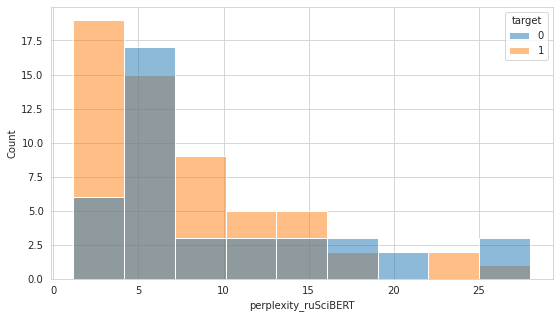

In [128]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(9, 5))
    sns.histplot(data=sample[sample['perplexity_ruSciBERT']<30], x='perplexity_ruSciBERT', hue='target')

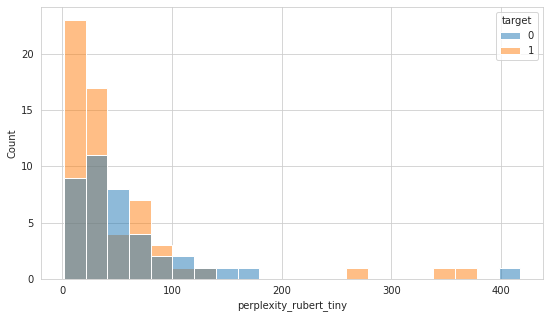

In [122]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(9, 5))
    sns.histplot(data=sample[sample['perplexity_rubert_tiny']<500], x='perplexity_rubert_tiny', hue='target')

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(9, 5))
    sns.histplot(data=sample[sample['perplexity_bert']<20], x='perplexity_bert', hue='target')

In [40]:
sample

Unnamed: 0                                               text  target  \
13817       13817  4.1. База данных Информация о пользователе сод...       1   
58690       58690  Различие между «корпоративным» POM’ом и корнев...       0   
49885       49885  Так и в случае с визуальным программированием ...       0   
42064       42064  На картинках ниже представлены результаты клас...       0   
51786       51786  Средний уровень позволяет уйти от С указателей...       0   
...           ...                                                ...     ...   
51978       51978  Это плоский «кусок» памяти, в котором находитс...       0   
3149         3149  На текущий момент сфера разработки программног...       1   
5757         5757  Модель проекта в Rider имеет много общего с мо...       1   
40640       40640  Этот CLI поддерживает MSTest, а также популярн...       0   
46725       46725  Настройки по-умолчанию отличные.MongoDB Тестов...       0   

       perplexity  perplexity_sberbank-ai/ruSciBERT  perplexity_rubert-tiny  
13817    2.798210                          2.798210                8.571547  
58690    9.613257                          9.613257               41.971765  
49885    4.592547                          4.592547               18.898452  
42064    6.697428                          6.697428               85.644731  
51786    7.405710                          7.405710               26.517145  
...           ...                               ...                     ...  
51978   15.676473                         15.676473               23.542011  
3149     2.046402                          2.046402                5.699791  
5757     8.215051                          8.215051              252.706553  
40640    8.620632                          8.620632               38.013708  
46725   14.202626                         14.202626              254.053947  

[100 rows x 6 columns]

## morphology analyze

In [16]:
!pip install navec
!pip install slovnet

     |████████████████████████████████| 46 kB 379 kB/s eta 0:00:011


In [7]:
import pymorphy2
from razdel import sentenize, tokenize
from navec import Navec
from slovnet import Morph
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
morph = pymorphy2.MorphAnalyzer()

In [8]:
morph = pymorphy2.MorphAnalyzer()

In [9]:
sents = test_df[test_df['target'] == 1].sample(3000)

In [10]:
sents

Unnamed: 0  Unnamed: 0.1  \
5046        63546          4320   
16508       75008          3772   
18666       77166          8095   
16          58516          6887   
9181        67681          7350   
...           ...           ...   
15325       73825          4710   
8913        67413          3231   
11643       70143          8726   
13867       72367          8939   
8564        67064          8133   

                                                    text  target  \
5046   Таким образом, функционализация имеет большое ...       1   
16508  Представляют собой набор корректных данных с о...       1   
18666  Важной особенностью современных мобильных проц...       1   
16                       Страница13 с лицензией проекта.       1   
9181   Для эффективного хранения и переиспользования ...       1   
...                                                  ...     ...   
15325        Проведена апробация реализованного решения.       1   
8913   Благодаря такому устройству объектов становитс...       1   
11643  Такой фаззер использует метод, который теорети...       1   
13867  Это предложение было принято сообществом, но д...       1   
8564   При разработке программного обеспечения может ...       1   

                                                   token  token_len  \
5046   [2, 9876, 5908, 16, 332, 4209, 865, 24550, 192...         34   
16508  [2, 13588, 14922, 18014, 6021, 29119, 23279, 1...         26   
18666  [2, 282, 17238, 1229, 11706, 11309, 19552, 324...         98   
16     [2, 297, 9412, 4541, 14432, 329, 22276, 679, 3...         13   
9181   [2, 3760, 341, 28588, 19953, 333, 16121, 320, ...         48   
...                                                  ...        ...   
15325  [2, 11424, 13127, 312, 28241, 2593, 2356, 328,...         15   
8913   [2, 20710, 28298, 331, 16474, 1373, 7084, 1328...         24   
11643  [2, 28446, 775, 332, 8264, 18125, 25301, 13130...         31   
13867  [2, 5130, 24889, 1563, 18825, 1154, 10658, 178...         21   
8564   [2, 3086, 28940, 24193, 1211, 19864, 3960, 815...         59   

                                                    pads  \
5046   [    2  9876  5908    16   332  4209   865 245...   
16508  [    2 13588 14922 18014  6021 29119 23279 105...   
18666  [    2   282 17238  1229 11706 11309 19552   3...   
16     [    2   297  9412  4541 14432   329 22276   6...   
9181   [    2  3760   341 28588 19953   333 16121   3...   
...                                                  ...   
15325  [    2 11424 13127   312 28241  2593  2356   3...   
8913   [    2 20710 28298   331 16474  1373  7084 132...   
11643  [    2 28446   775   332  8264 18125 25301 131...   
13867  [    2  5130 24889  1563 18825  1154 10658 178...   
8564   [    2  3086 28940 24193  1211 19864  3960   8...   

                                         attention_masks  prediction  
5046   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
16508  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
18666  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
16     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           0  
9181   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
...                                                  ...         ...  
15325  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
8913   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
11643  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  
13867  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           0  
8564   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           1  

[3000 rows x 9 columns]

In [11]:
sents['doc_object'] = sents.text.apply(Doc) 

In [12]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [45]:
for sent in sents.doc_object:
    if " Я " in sent.text or " я " in sent.text:
            #print("From text:", sent.text)
            for token in sent.morph.tokens:
                pass
                #print(token)
            
    for token in sent.morph.tokens:
        #print(token)
        print(sent)
        if token.pos == "VERB":
            if "Number" in token.feats and "Person" in token.feats:
                if token.feats['Person'] == "1" and token.feats["Number"] == "Sing":
                    pass
                    #print("From token:", sent.text)
                

Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])
Doc(text='Таким образом, функционализация имеет большое зна..., tokens=[...], sents=[...])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='На RDF графах алгоритм работал не менее чем в два..., tokens=[...], sents=[...])
Doc(text='Прежде всего стоит обратить внимание на используе..., tokens=[...], sents=[...]

Exception ignored in: <function tqdm.__del__ at 0x7f41401484c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1137, in __del__
    def __del__(self):
KeyboardInterrupt: 


Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])
Doc(text='После загрузки пакета в PyPI пользователи могут н..., tokens=[...], sents=[...])

# записки

по простой эвристике квалифицировать

наташей пройтись по орфографии

добавить формалити



мечты:  
обучить маленькую сетку на данных размеченных этим:  
формалити  
тяжелый берт  